In [4]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from pettingzoo.classic import texas_holdem_v4
from stable_baselines3 import A2C
from stable_baselines3.common.env_checker import check_env

import matplotlib.pyplot as plt
import pickle
import os
# import imageio


In [5]:
class SingleAgentWrapper(gym.Env):
    """Convert PettingZoo Texas Hold'em into single-agent SB3-friendly env."""

    metadata = {"render_modes": ["rgb_array"]}

    def __init__(self):
        super().__init__()
        self.env = texas_holdem_v4.env()
        self.env.reset()

        self.agent = self.env.agents[0]
        
        obs_dict, _, _, _, _ = self.env.last()
        obs = obs_dict["observation"]
        action_mask = obs_dict["action_mask"]

        # OBS space
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=obs.shape, dtype=obs.dtype
        )

        # Action space
        self.action_space = spaces.Discrete(len(action_mask))

        # store mask
        self.last_mask = action_mask

    def reset(self, seed=None, options=None):
        self.env.reset(seed=seed)
        obs_dict, _, _, _, _ = self.env.last()
        self.last_mask = obs_dict["action_mask"]
        return obs_dict["observation"], {}

    def step(self, action):
        # --- Enforce legal action (most important part) ---
        if self.last_mask[action] == 0:
            legal = np.where(self.last_mask == 1)[0]
            action = np.random.choice(legal)

        # Player 0 move
        self.env.step(action)

        # Opponent random move
        opp = self.env.agents[1]
        if not self.env.terminations[opp]:
            obs_dict, _, _, _, _ = self.env.last()
            legal = obs_dict["action_mask"]
            opp_action = np.random.choice(np.where(legal == 1)[0])
            self.env.step(opp_action)

        # Next obs
        obs_dict, reward, terminated, truncated, info = self.env.last()
        self.last_mask = obs_dict["action_mask"]

        return obs_dict["observation"], reward, terminated, truncated, info


### Check Environment

In [6]:
test_env = SingleAgentWrapper()
check_env(test_env, warn=True)
print("Environment OK!")

Environment OK!


### Run Directory Helper

In [7]:
def make_run_dir(base="runs/a2c"):
    os.makedirs("runs", exist_ok=True)
    os.makedirs(base, exist_ok=True)

    run_id = 1
    while os.path.exists(f"{base}_run_{run_id}"):
        run_id += 1

    run_dir = f"{base}_run_{run_id}"
    os.makedirs(run_dir)
    print(f"Created directory: {run_dir}")
    return run_dir


### Evaluation Function

In [8]:
def evaluate(model, episodes=20):
    env_eval = SingleAgentWrapper()
    rewards = []

    for _ in range(episodes):
        obs, _ = env_eval.reset()
        done = False
        total = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, _ = env_eval.step(action)
            total += reward
        rewards.append(total)

    return np.mean(rewards), rewards


In [9]:
import imageio
from pettingzoo.classic import texas_holdem_v4

# Decode card ID (0–51) -> "A of Hearts"
value_map = {
    1: "A", 2: "2", 3: "3", 4:"4", 5:"5", 6:"6",
    7:"7", 8:"8", 9:"9", 10:"10", 11:"J", 12:"Q", 13:"K"
}
suit_map = {0:"Hearts", 1:"Diamonds", 2:"Clubs", 3:"Spades"}

def decode_card(card_id):
    value = (card_id % 13) + 1
    suit = card_id // 13
    return f"{value_map[value]} of {suit_map[suit]}"

def extract_visible_cards(env, player):
    """
    Extract hole cards + community cards for a given player.
    This works for PettingZoo TexasHoldem.
    """
    cards = []

    # Private (hole) cards: 2 cards per player
    try:
        hole = env.env.hands[player]   # a list of 2 card IDs
        for cid in hole:
            cards.append(decode_card(cid))
    except:
        pass

    # Public cards (flop/turn/river)
    try:
        for cid in env.env.community_cards:
            cards.append(decode_card(cid))
    except:
        pass

    return cards


def generate_pretty_poker_gif_verbose(model=None, path="poker.gif", max_steps=200):
    """
    Generates:
    - High-quality Poker GIF
    - Console text logs (same as your PPO teammate!)
    """
    env = texas_holdem_v4.env(render_mode="rgb_array")
    env.reset()

    frames = []
    obs_dict, reward, terminated, truncated, _ = env.last()

    total_reward = 0
    step = 0

    while not (terminated or truncated) and step < max_steps:
        frame = env.render()          # high quality frame
        frames.append(frame)

        player = env.agent_selection  # player_0 or player_1
        visible = extract_visible_cards(env, player)

        print("\n-------------------")
        print(player)
        print(f"Visible cards: {visible}")
        print(f"Reward so far: {total_reward}")

        obs = obs_dict["observation"]
        mask = obs_dict["action_mask"]

        # ---- Choose action ----
        if model is None:
            legal = np.where(mask == 1)[0]
            action = int(np.random.choice(legal))
        else:
            action_pred, _ = model.predict(obs, deterministic=True)
            action = int(action_pred)  # convert numpy scalar -> int

            # illegal fix
            if mask[action] == 0:
                legal = np.where(mask == 1)[0]
                action = int(np.random.choice(legal))

        action_names = {0:"Fold", 1:"Call", 2:"Raise", 3:"Check", 4:"Bet"}
        action_name = action_names.get(action, str(action))
        print(f"Chosen action: {action_name}")
        print("-------------------")

        # ---- Step ----
        env.step(action)
        obs_dict, reward, terminated, truncated, _ = env.last()
        total_reward += reward
        step += 1

    # Save GIF
    imageio.mimsave(path, frames, fps=2)
    print(f"Saved to {path}")


### Start Training

In [10]:
run_dir = make_run_dir()

env = SingleAgentWrapper()
model = A2C("MlpPolicy", env, verbose=1, learning_rate=7e-4, gamma=0.99)

TIMESTEPS_PER_ITER = 5000
N_ITERS = 40  # 40 * 5000 = 200k steps

reward_history = []

for i in range(N_ITERS):
    model.learn(total_timesteps=TIMESTEPS_PER_ITER, reset_num_timesteps=False)
    mean_r, _ = evaluate(model, episodes=20)
    reward_history.append(mean_r)
    print(f"Iter {i+1}/{N_ITERS} | mean reward = {mean_r:.3f}")

# Save model
model.save(f"{run_dir}/a2c_model.zip")

# Save reward history
with open(f"{run_dir}/reward_history.pkl", "wb") as f:
    pickle.dump(reward_history, f)

print(f"Model + history saved to folder: {run_dir}")


Created directory: runs/a2c_run_1
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.9      |
|    ep_rew_mean        | 0.035    |
| time/                 |          |
|    fps                | 673      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.35    |
|    explained_variance | -0.798   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 4.61     |
|    value_loss         | 10.8     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.7      |
|    ep_rew_mean        | 0.235    |
| time/                 |          |
|    fps                | 737      |
|    iterations      

### Plot Training Curve

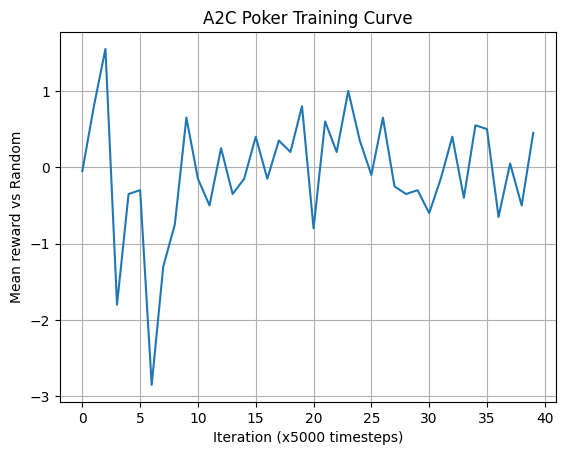

In [11]:
plt.plot(reward_history)
plt.xlabel("Iteration (x5000 timesteps)")
plt.ylabel("Mean reward vs Random")
plt.title("A2C Poker Training Curve")
plt.grid()
plt.savefig(f"{run_dir}/training_curve.png")
plt.show()


In [12]:
# Before training (random baseline)
generate_pretty_poker_gif_verbose(
    model=None,
    path=f"{run_dir}/before_training_verbose.gif"
)

# After training (A2C policy)
generate_pretty_poker_gif_verbose(
    model=model,
    path=f"{run_dir}/after_training_verbose.gif"
)



-------------------
player_0
Visible cards: []
Reward so far: 0
Chosen action: Call
-------------------

-------------------
player_1
Visible cards: []
Reward so far: 0
Chosen action: Call
-------------------

-------------------
player_0
Visible cards: []
Reward so far: 0
Chosen action: Fold
-------------------

-------------------
player_1
Visible cards: []
Reward so far: 0
Chosen action: Check
-------------------

-------------------
player_0
Visible cards: []
Reward so far: 0
Chosen action: Call
-------------------

-------------------
player_1
Visible cards: []
Reward so far: 0
Chosen action: Call
-------------------

-------------------
player_0
Visible cards: []
Reward so far: 0
Chosen action: Fold
-------------------

-------------------
player_1
Visible cards: []
Reward so far: 0
Chosen action: Call
-------------------

-------------------
player_0
Visible cards: []
Reward so far: 0
Chosen action: Fold
-------------------

-------------------
player_1
Visible cards: []
Reward

### Model Comparison

In [13]:
def eval_a2c_vs_random(model, num_episodes=500):
    """
    Evaluate A2C (player_0) vs Random (player_1)
    SB3 model -> SingleAgentWrapper baseline logic
    """
    rewards_p0 = []

    for ep in range(num_episodes):
        env = texas_holdem_v4.env()
        env.reset()
        ep_reward_0 = 0

        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()

            if agent == "player_0":
                ep_reward_0 += reward

            done = termination or truncation
            if done:
                action = None
            else:
                mask = np.asarray(obs["action_mask"])
                legal = np.where(mask > 0)[0]

                if agent == "player_0":
                    # ---- A2C chooses action ----
                    a, _ = model.predict(obs["observation"], deterministic=True)
                    a = int(a)

                    if mask[a] == 0:
                        a = int(np.random.choice(legal))
                    action = a
                else:
                    # ---- Random opponent ----
                    action = int(np.random.choice(legal))

            env.step(action)

        rewards_p0.append(ep_reward_0)

    rewards_p0 = np.array(rewards_p0)
    win_rate = float(np.mean(rewards_p0 > 0))
    tie_rate = float(np.mean(rewards_p0 == 0))
    loss_rate = float(np.mean(rewards_p0 < 0))
    mean_reward = float(rewards_p0.mean())

    print(f"[A2C vs Random] over {num_episodes} episodes:")
    print(f"  Win rate : {win_rate:.3f}")
    print(f"  Tie rate : {tie_rate:.3f}")
    print(f"  Loss rate: {loss_rate:.3f}")
    print(f"  Mean reward: {mean_reward:.3f}")

    return {
        "win_rate": win_rate,
        "tie_rate": tie_rate,
        "loss_rate": loss_rate,
        "mean_reward": mean_reward
    }


In [14]:
a2c_stats = eval_a2c_vs_random(model, num_episodes=500)
a2c_stats


[A2C vs Random] over 500 episodes:
  Win rate : 0.718
  Tie rate : 0.010
  Loss rate: 0.272
  Mean reward: 0.788


{'win_rate': 0.718, 'tie_rate': 0.01, 'loss_rate': 0.272, 'mean_reward': 0.788}

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "Agent": ["A2C (learner)"],
    "Opponent": ["Random"],
    "Win Rate": [a2c_stats["win_rate"]],
    "Mean Reward": [a2c_stats["mean_reward"]]
})

df


,Agent,Opponent,Win Rate,Mean Reward
0,A2C (learner),Random,0.718,0.788


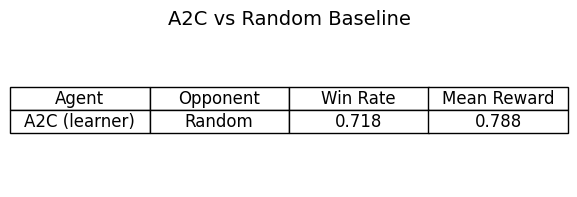

In [16]:
fig, ax = plt.subplots(figsize=(6,2))
ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.4)

plt.title("A2C vs Random Baseline", fontsize=14)
plt.savefig(f"{run_dir}/a2c_vs_random.png", dpi=200, bbox_inches='tight')
plt.show()
